# 🎯 Proyecto Integrador 1: Pipeline ETL Completo

## Descripción del Proyecto

En este proyecto integrador, construirás un **pipeline ETL completo** que integra todos los conceptos aprendidos:

- ✅ Extracción de datos desde múltiples fuentes (CSV, API, Base de Datos)
- ✅ Transformación y limpieza de datos con Pandas
- ✅ Validación de calidad de datos
- ✅ Visualización de resultados
- ✅ Almacenamiento en base de datos SQLite
- ✅ Generación de reportes

---

## 📋 Requisitos del Proyecto

### Funcionalidades Requeridas:

1. **Extracción** de datos desde:
   - Archivos CSV locales
   - API REST pública
   - Base de datos SQLite

2. **Transformación** que incluya:
   - Limpieza de valores nulos
   - Normalización de formatos
   - Cálculo de métricas agregadas
   - Enriquecimiento con datos externos

3. **Carga** de datos transformados:
   - Base de datos SQLite
   - Archivos Parquet para análisis

4. **Visualización** de insights:
   - Dashboard con matplotlib/seaborn
   - Métricas clave (KPIs)

5. **Logging** y manejo de errores

---

## 1. Configuración Inicial

In [2]:
# Importaciones
import pandas as pd
import numpy as np
import requests
import sqlite3
import logging
from datetime import datetime, timedelta
from typing import List, Dict, Optional, Tuple
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import json

warnings.filterwarnings('ignore')

# Crear directorios necesarios ANTES de configurar logging
os.makedirs('../../outputs/proyecto_1', exist_ok=True)
os.makedirs('../../logs', exist_ok=True)

# Configurar logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler('../../logs/proyecto_integrador_1.log'),
        logging.StreamHandler()
    ]
)

logger = logging.getLogger(__name__)

print("✅ Configuración inicial completada")
logger.info("Proyecto Integrador 1 iniciado")

2025-12-07 17:24:47,686 - INFO - Proyecto Integrador 1 iniciado


✅ Configuración inicial completada


### 🔧 Setup de Proyecto: Logging y Estructura

**Concepto:** Proyectos profesionales requieren logging, manejo de errores y estructura de directorios organizada.

**Elementos clave:**
- **Logging:** `logging.basicConfig()` registra eventos en archivo + consola
- **Directorios:** `os.makedirs()` crea outputs/, logs/ si no existen
- **Logger:** seguimiento de ejecución, errores, métricas de performance

**Niveles de logging:**
- INFO: eventos normales del flujo
- WARNING: situaciones inusuales pero manejables
- ERROR: errores que impiden operaciones específicas
- CRITICAL: fallos que detienen la aplicación

**Objetivo:** Trazabilidad completa del pipeline para debugging y auditoría.

## 2. Extracción de Datos

### 2.1 Clase DataExtractor

In [3]:
class DataExtractor:
    """
    Extractor de datos desde múltiples fuentes.
    """
    
    def __init__(self):
        self.logger = logging.getLogger(__name__)
    
    def extract_csv(self, filepath: str) -> Optional[pd.DataFrame]:
        """
        Extrae datos desde archivo CSV.
        """
        try:
            self.logger.info(f"Extrayendo datos de CSV: {filepath}")
            df = pd.read_csv(filepath)
            self.logger.info(f"✅ CSV extraído: {len(df)} registros")
            return df
        except FileNotFoundError:
            self.logger.error(f"❌ Archivo no encontrado: {filepath}")
            return None
        except Exception as e:
            self.logger.error(f"❌ Error al leer CSV: {str(e)}")
            return None
    
    def extract_api(self, url: str, params: Optional[Dict] = None) -> Optional[pd.DataFrame]:
        """
        Extrae datos desde API REST.
        """
        try:
            self.logger.info(f"Consultando API: {url}")
            response = requests.get(url, params=params, timeout=30)
            response.raise_for_status()
            
            data = response.json()
            df = pd.DataFrame(data)
            
            self.logger.info(f"✅ API consultada: {len(df)} registros")
            return df
        except requests.exceptions.RequestException as e:
            self.logger.error(f"❌ Error en petición API: {str(e)}")
            return None
        except Exception as e:
            self.logger.error(f"❌ Error procesando respuesta API: {str(e)}")
            return None
    
    def extract_sqlite(self, db_path: str, query: str) -> Optional[pd.DataFrame]:
        """
        Extrae datos desde base de datos SQLite.
        """
        try:
            self.logger.info(f"Consultando SQLite: {db_path}")
            conn = sqlite3.connect(db_path)
            df = pd.read_sql_query(query, conn)
            conn.close()
            
            self.logger.info(f"✅ SQLite consultado: {len(df)} registros")
            return df
        except sqlite3.Error as e:
            self.logger.error(f"❌ Error en SQLite: {str(e)}")
            return None
        except Exception as e:
            self.logger.error(f"❌ Error general: {str(e)}")
            return None

print("✅ Clase DataExtractor definida")

✅ Clase DataExtractor definida


### 📥 DataExtractor: Extracción Multi-Fuente

**Concepto:** Clase unificada que extrae datos desde CSV, APIs y bases de datos, con manejo de errores consistente.

**Patrón de diseño:**
- Métodos específicos por fuente: `extract_csv()`, `extract_api()`, `extract_db()`
- Try/except en cada método para capturar errores específicos
- Logging para cada operación (éxito/fallo)
- Retorno `Optional[pd.DataFrame]` permite manejar None en failures

**Ventaja:** Código reutilizable, testeable, y con logging centralizado.

**Uso en producción:** Base para pipelines Airflow, Luigi, Prefect.

### 2.2 Ejecutar Extracciones

In [4]:
# Crear extractor
extractor = DataExtractor()

# 1. Extraer ventas desde CSV
df_ventas = extractor.extract_csv('../../datasets/raw/ventas.csv')

# 2. Extraer productos desde CSV
df_productos = extractor.extract_csv('../../datasets/raw/productos.csv')

# 3. Extraer clientes desde CSV
df_clientes = extractor.extract_csv('../../datasets/raw/clientes.csv')

# 4. Extraer datos de usuarios desde API pública
df_usuarios_api = extractor.extract_api('https://jsonplaceholder.typicode.com/users')

# Verificar extracciones
print("\n📊 RESUMEN DE EXTRACCIÓN")
print("=" * 50)
print(f"Ventas: {len(df_ventas) if df_ventas is not None else 0} registros")
print(f"Productos: {len(df_productos) if df_productos is not None else 0} registros")
print(f"Clientes: {len(df_clientes) if df_clientes is not None else 0} registros")
print(f"Usuarios API: {len(df_usuarios_api) if df_usuarios_api is not None else 0} registros")

2025-12-07 17:24:55,425 - INFO - Extrayendo datos de CSV: ../../datasets/raw/ventas.csv
2025-12-07 17:24:55,429 - INFO - ✅ CSV extraído: 50 registros
2025-12-07 17:24:55,430 - INFO - Extrayendo datos de CSV: ../../datasets/raw/productos.csv
2025-12-07 17:24:55,432 - INFO - ✅ CSV extraído: 30 registros
2025-12-07 17:24:55,433 - INFO - Extrayendo datos de CSV: ../../datasets/raw/clientes.csv
2025-12-07 17:24:55,429 - INFO - ✅ CSV extraído: 50 registros
2025-12-07 17:24:55,430 - INFO - Extrayendo datos de CSV: ../../datasets/raw/productos.csv
2025-12-07 17:24:55,432 - INFO - ✅ CSV extraído: 30 registros
2025-12-07 17:24:55,433 - INFO - Extrayendo datos de CSV: ../../datasets/raw/clientes.csv
2025-12-07 17:24:55,436 - INFO - ✅ CSV extraído: 30 registros
2025-12-07 17:24:55,437 - INFO - Consultando API: https://jsonplaceholder.typicode.com/users
2025-12-07 17:24:55,436 - INFO - ✅ CSV extraído: 30 registros
2025-12-07 17:24:55,437 - INFO - Consultando API: https://jsonplaceholder.typicode.co


📊 RESUMEN DE EXTRACCIÓN
Ventas: 50 registros
Productos: 30 registros
Clientes: 30 registros
Usuarios API: 10 registros


## 3. Transformación de Datos

### 3.1 Clase DataTransformer

In [5]:
class DataTransformer:
    """
    Transformador de datos con validación y limpieza.
    """
    
    def __init__(self):
        self.logger = logging.getLogger(__name__)
    
    def clean_nulls(self, df: pd.DataFrame, strategy: str = 'drop') -> pd.DataFrame:
        """
        Limpia valores nulos.
        """
        nulos_antes = df.isnull().sum().sum()
        
        if strategy == 'drop':
            df_clean = df.dropna()
        elif strategy == 'fill_mean':
            df_clean = df.copy()
            numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
            df_clean[numeric_cols] = df_clean[numeric_cols].fillna(df_clean[numeric_cols].mean())
        elif strategy == 'fill_mode':
            df_clean = df.copy()
            for col in df_clean.columns:
                if df_clean[col].isnull().any():
                    df_clean[col].fillna(df_clean[col].mode()[0], inplace=True)
        else:
            df_clean = df.copy()
        
        nulos_despues = df_clean.isnull().sum().sum()
        self.logger.info(f"Nulos: {nulos_antes} → {nulos_despues}")
        
        return df_clean
    
    def normalize_dates(self, df: pd.DataFrame, date_columns: List[str]) -> pd.DataFrame:
        """
        Normaliza columnas de fechas.
        """
        df_norm = df.copy()
        
        for col in date_columns:
            if col in df_norm.columns:
                df_norm[col] = pd.to_datetime(df_norm[col], errors='coerce')
                self.logger.info(f"✅ Fecha normalizada: {col}")
        
        return df_norm
    
    def remove_duplicates(self, df: pd.DataFrame, subset: Optional[List[str]] = None) -> pd.DataFrame:
        """
        Elimina duplicados.
        """
        duplicados_antes = df.duplicated(subset=subset).sum()
        df_clean = df.drop_duplicates(subset=subset)
        duplicados_eliminados = duplicados_antes
        
        self.logger.info(f"Duplicados eliminados: {duplicados_eliminados}")
        
        return df_clean
    
    def enrich_data(self, df_base: pd.DataFrame, df_enrich: pd.DataFrame, 
                   on: str, how: str = 'left') -> pd.DataFrame:
        """
        Enriquece datos con merge.
        """
        try:
            df_enriched = df_base.merge(df_enrich, on=on, how=how)
            nuevas_cols = len(df_enriched.columns) - len(df_base.columns)
            self.logger.info(f"✅ Datos enriquecidos: +{nuevas_cols} columnas")
            return df_enriched
        except Exception as e:
            self.logger.error(f"❌ Error en enriquecimiento: {str(e)}")
            return df_base
    
    def calculate_metrics(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Calcula métricas derivadas.
        """
        df_metrics = df.copy()
        
        # Ejemplo: calcular total si hay cantidad y precio
        if 'cantidad' in df_metrics.columns and 'precio_unitario' in df_metrics.columns:
            if 'total' not in df_metrics.columns:
                df_metrics['total_calculado'] = df_metrics['cantidad'] * df_metrics['precio_unitario']
                self.logger.info("✅ Métrica 'total_calculado' generada")
        
        return df_metrics

print("✅ Clase DataTransformer definida")

✅ Clase DataTransformer definida


### 🔄 DataTransformer: Transformaciones Estandarizadas

**Concepto:** Clase con métodos para transformaciones comunes del pipeline ETL.

**Transformaciones incluidas:**
- **clean_nulls():** múltiples estrategias (drop, fill_mean, fill_mode)
- **normalize_dates():** conversión robusta con `errors='coerce'`
- **remove_duplicates():** eliminación con logging de cantidad
- **enrich_data():** joins/merges para enriquecimiento

**Patrón:**
1. Copiar DataFrame original (`df.copy()`)
2. Aplicar transformación
3. Logear métricas (antes/después)
4. Retornar DataFrame transformado

**Ventaja:** Cada transformación es una unidad testeable y auditable.

### 3.2 Aplicar Transformaciones

In [7]:
# Crear transformador
transformer = DataTransformer()

print("🔄 INICIANDO TRANSFORMACIONES\n")

# 1. Limpiar nulos en ventas
df_ventas_clean = transformer.clean_nulls(df_ventas, strategy='drop')

# 2. Normalizar fechas
df_ventas_clean = transformer.normalize_dates(df_ventas_clean, ['fecha_venta'])
df_clientes_clean = transformer.normalize_dates(df_clientes, ['fecha_registro'])

# 3. Eliminar duplicados
df_ventas_clean = transformer.remove_duplicates(df_ventas_clean, subset=['venta_id'])
df_productos_clean = transformer.remove_duplicates(df_productos, subset=['producto'])

# 4. Crear columna producto_id en productos para el merge
# (Los productos se identifican por su nombre único)
df_productos_clean['producto_id'] = range(1, len(df_productos_clean) + 1)

# 5. Crear diccionario producto -> producto_id para mapear
producto_map = dict(zip(df_productos_clean['producto'], df_productos_clean['producto_id']))

# 6. Verificar si producto_id en ventas es nombre o ID
# Si es nombre, mapearlo a ID numérico
if df_ventas_clean['producto_id'].dtype == 'object':
    df_ventas_clean['producto_id_num'] = df_ventas_clean['producto_id'].map(producto_map)
    df_ventas_clean['producto_id_num'] = df_ventas_clean['producto_id_num'].fillna(df_ventas_clean['producto_id'])
else:
    df_ventas_clean['producto_id_num'] = df_ventas_clean['producto_id']

# 7. Enriquecer ventas con productos
df_ventas_enriched = transformer.enrich_data(
    df_ventas_clean, 
    df_productos_clean, 
    on='producto_id'
)

# 8. Enriquecer con clientes
df_ventas_final = transformer.enrich_data(
    df_ventas_enriched,
    df_clientes_clean[['cliente_id', 'segmento', 'ciudad', 'pais']],
    on='cliente_id'
)

# 9. Calcular métricas adicionales
# Margen: diferencia entre total facturado y costo (precio_unitario * cantidad)
df_ventas_final['costo_total'] = df_ventas_final['precio_unitario'] * df_ventas_final['cantidad']
df_ventas_final['margen'] = ((df_ventas_final['total'] - df_ventas_final['costo_total']) / df_ventas_final['total'] * 100).round(2)
df_ventas_final['mes'] = df_ventas_final['fecha_venta'].dt.to_period('M').astype(str)
df_ventas_final['trimestre'] = df_ventas_final['fecha_venta'].dt.to_period('Q').astype(str)

print("\n✅ TRANSFORMACIONES COMPLETADAS")
print("=" * 50)
print(f"Registros finales: {len(df_ventas_final)}")
print(f"Columnas totales: {len(df_ventas_final.columns)}")
print(f"\nPrimeras columnas:")
print(df_ventas_final.columns.tolist()[:10])

display(df_ventas_final.head())

2025-12-07 17:27:11,224 - INFO - Nulos: 0 → 0
2025-12-07 17:27:11,226 - INFO - ✅ Fecha normalizada: fecha_venta
2025-12-07 17:27:11,227 - INFO - ✅ Fecha normalizada: fecha_registro
2025-12-07 17:27:11,228 - INFO - Duplicados eliminados: 0
2025-12-07 17:27:11,226 - INFO - ✅ Fecha normalizada: fecha_venta
2025-12-07 17:27:11,227 - INFO - ✅ Fecha normalizada: fecha_registro
2025-12-07 17:27:11,228 - INFO - Duplicados eliminados: 0
2025-12-07 17:27:11,230 - INFO - Duplicados eliminados: 0
2025-12-07 17:27:11,233 - INFO - ✅ Datos enriquecidos: +5 columnas
2025-12-07 17:27:11,230 - INFO - Duplicados eliminados: 0
2025-12-07 17:27:11,233 - INFO - ✅ Datos enriquecidos: +5 columnas
2025-12-07 17:27:11,236 - INFO - ✅ Datos enriquecidos: +3 columnas
2025-12-07 17:27:11,236 - INFO - ✅ Datos enriquecidos: +3 columnas


🔄 INICIANDO TRANSFORMACIONES


✅ TRANSFORMACIONES COMPLETADAS
Registros finales: 50
Columnas totales: 22

Primeras columnas:
['venta_id', 'cliente_id', 'producto_id', 'cantidad', 'precio_unitario', 'total', 'fecha_venta', 'metodo_pago', 'estado', 'producto_id_num']


,venta_id,cliente_id,producto_id,cantidad,precio_unitario,total,fecha_venta,metodo_pago,estado,producto_id_num,...,precio,stock,proveedor,segmento,ciudad,pais,costo_total,margen,mes,trimestre
0,1,1,1,1,1299.99,1299.99,2024-01-15,tarjeta_credito,completado,1,...,1299.99,45,TechSupply Inc,Premium,Madrid,España,1299.99,0.0,2024-01,2024Q1
1,2,2,3,2,79.99,159.98,2024-01-16,paypal,completado,3,...,79.99,150,Logitech Corp,Standard,Barcelona,España,159.98,0.0,2024-01,2024Q1
2,3,3,5,1,349.99,349.99,2024-01-17,tarjeta_debito,completado,5,...,349.99,60,Samsung Electronics,Premium,Valencia,España,349.99,0.0,2024-01,2024Q1
3,4,1,7,2,149.99,299.98,2024-01-18,tarjeta_credito,completado,7,...,149.99,200,Samsung Electronics,Premium,Madrid,España,299.98,0.0,2024-01,2024Q1
4,5,4,4,1,129.99,129.99,2024-01-19,transferencia,completado,4,...,129.99,85,Razer Inc,Standard,Sevilla,España,129.99,0.0,2024-01,2024Q1


## 4. Validación de Calidad de Datos

### 4.1 Clase DataQualityValidator

In [8]:
class DataQualityValidator:
    """
    Validador de calidad de datos.
    """
    
    def __init__(self):
        self.logger = logging.getLogger(__name__)
        self.issues = []
    
    def validate_completeness(self, df: pd.DataFrame, threshold: float = 0.95) -> bool:
        """
        Valida que los datos estén completos (sin nulos).
        """
        total_values = df.size
        non_null_values = df.count().sum()
        completeness = non_null_values / total_values
        
        if completeness < threshold:
            msg = f"❌ Completitud baja: {completeness:.2%} (umbral: {threshold:.2%})"
            self.issues.append(msg)
            self.logger.warning(msg)
            return False
        else:
            self.logger.info(f"✅ Completitud OK: {completeness:.2%}")
            return True
    
    def validate_uniqueness(self, df: pd.DataFrame, columns: List[str]) -> bool:
        """
        Valida unicidad en columnas clave.
        """
        duplicates = df.duplicated(subset=columns).sum()
        
        if duplicates > 0:
            msg = f"❌ Duplicados encontrados: {duplicates} en {columns}"
            self.issues.append(msg)
            self.logger.warning(msg)
            return False
        else:
            self.logger.info(f"✅ Unicidad OK en {columns}")
            return True
    
    def validate_ranges(self, df: pd.DataFrame, column: str, min_val: float, max_val: float) -> bool:
        """
        Valida que los valores estén en un rango válido.
        """
        out_of_range = df[(df[column] < min_val) | (df[column] > max_val)]
        
        if len(out_of_range) > 0:
            msg = f"❌ {len(out_of_range)} valores fuera de rango en '{column}' [{min_val}, {max_val}]"
            self.issues.append(msg)
            self.logger.warning(msg)
            return False
        else:
            self.logger.info(f"✅ Rango OK en '{column}'")
            return True
    
    def generate_report(self) -> str:
        """
        Genera reporte de calidad.
        """
        report = "\n" + "=" * 60 + "\n"
        report += "📊 REPORTE DE CALIDAD DE DATOS\n"
        report += "=" * 60 + "\n"
        
        if not self.issues:
            report += "\n✅ No se encontraron problemas de calidad\n"
        else:
            report += f"\n⚠️ Se encontraron {len(self.issues)} problemas:\n\n"
            for i, issue in enumerate(self.issues, 1):
                report += f"{i}. {issue}\n"
        
        report += "\n" + "=" * 60
        
        return report

print("✅ Clase DataQualityValidator definida")

✅ Clase DataQualityValidator definida


### ✅ DataQualityValidator: Validaciones Automatizadas

**Concepto:** Validador que verifica calidad de datos antes de cargar a destino.

**Validaciones típicas:**
- **Completeness:** % valores no nulos ≥ threshold
- **Uniqueness:** no duplicados en claves primarias
- **Accuracy:** valores dentro de rangos válidos
- **Consistency:** formatos y tipos de datos correctos

**Patrón:**
- Acumular issues en lista
- Retornar bool (pass/fail)
- Logear cada validación
- Detener pipeline si validaciones críticas fallan

**Uso:** Gate de calidad antes de stage "Load", esencial en producción.

### 4.2 Ejecutar Validaciones

In [9]:
# Crear validador
validator = DataQualityValidator()

print("🔍 VALIDANDO CALIDAD DE DATOS\n")

# 1. Completitud
validator.validate_completeness(df_ventas_final, threshold=0.90)

# 2. Unicidad en ventas
validator.validate_uniqueness(df_ventas_final, ['venta_id'])

# 3. Rangos válidos
validator.validate_ranges(df_ventas_final, 'cantidad', min_val=0, max_val=100)
validator.validate_ranges(df_ventas_final, 'total', min_val=0, max_val=100000)

# Generar reporte
report = validator.generate_report()
print(report)

# Guardar reporte
with open('../../outputs/proyecto_1/reporte_calidad.txt', 'w', encoding='utf-8') as f:
    f.write(report)

logger.info("Reporte de calidad generado")

2025-12-07 17:27:22,523 - INFO - ✅ Completitud OK: 100.00%
2025-12-07 17:27:22,524 - INFO - ✅ Unicidad OK en ['venta_id']
2025-12-07 17:27:22,525 - INFO - ✅ Rango OK en 'cantidad'
2025-12-07 17:27:22,528 - INFO - ✅ Rango OK en 'total'
2025-12-07 17:27:22,529 - INFO - Reporte de calidad generado
2025-12-07 17:27:22,524 - INFO - ✅ Unicidad OK en ['venta_id']
2025-12-07 17:27:22,525 - INFO - ✅ Rango OK en 'cantidad'
2025-12-07 17:27:22,528 - INFO - ✅ Rango OK en 'total'
2025-12-07 17:27:22,529 - INFO - Reporte de calidad generado


🔍 VALIDANDO CALIDAD DE DATOS


📊 REPORTE DE CALIDAD DE DATOS

✅ No se encontraron problemas de calidad



## 5. Análisis y Agregaciones

### 5.1 Métricas de Negocio

In [10]:
# KPIs principales
kpis = {
    'total_ventas': df_ventas_final['total'].sum(),
    'num_transacciones': len(df_ventas_final),
    'ticket_promedio': df_ventas_final['total'].mean(),
    'ticket_mediano': df_ventas_final['total'].median(),
    'clientes_unicos': df_ventas_final['cliente_id'].nunique(),
    'productos_vendidos': df_ventas_final['producto'].nunique(),
    'margen_promedio': df_ventas_final['margen'].mean()
}

print("📊 KPIs PRINCIPALES")
print("=" * 60)
print(f"💰 Total Ventas: ${kpis['total_ventas']:,.2f}")
print(f"🛒 Transacciones: {kpis['num_transacciones']:,}")
print(f"📈 Ticket Promedio: ${kpis['ticket_promedio']:.2f}")
print(f"📊 Ticket Mediano: ${kpis['ticket_mediano']:.2f}")
print(f"👥 Clientes Únicos: {kpis['clientes_unicos']}")
print(f"📦 Productos Vendidos: {kpis['productos_vendidos']}")
print(f"💹 Margen Promedio: {kpis['margen_promedio']:.2f}%")

# Guardar KPIs
with open('../../outputs/proyecto_1/kpis.json', 'w') as f:
    json.dump(kpis, f, indent=2)

logger.info("KPIs calculados y guardados")

2025-12-07 17:27:25,476 - INFO - KPIs calculados y guardados


📊 KPIs PRINCIPALES
💰 Total Ventas: $18,179.10
🛒 Transacciones: 50
📈 Ticket Promedio: $363.58
📊 Ticket Mediano: $219.98
👥 Clientes Únicos: 30
📦 Productos Vendidos: 30
💹 Margen Promedio: 0.00%


### 5.2 Agregaciones por Dimensiones

In [11]:
# Ventas por categoría
ventas_categoria = df_ventas_final.groupby('categoria').agg({
    'total': 'sum',
    'venta_id': 'count',
    'margen': 'mean'
}).round(2)
ventas_categoria.columns = ['total_ventas', 'num_ventas', 'margen_promedio']
ventas_categoria = ventas_categoria.sort_values('total_ventas', ascending=False)

print("\n📊 VENTAS POR CATEGORÍA")
display(ventas_categoria)

# Ventas por segmento de cliente
ventas_segmento = df_ventas_final.groupby('segmento').agg({
    'total': ['sum', 'mean', 'count']
}).round(2)
ventas_segmento.columns = ['total_ventas', 'ticket_promedio', 'num_transacciones']
ventas_segmento = ventas_segmento.sort_values('total_ventas', ascending=False)

print("\n👥 VENTAS POR SEGMENTO DE CLIENTE")
display(ventas_segmento)

# Ventas por mes
ventas_mes = df_ventas_final.groupby('mes').agg({
    'total': 'sum',
    'venta_id': 'count'
}).round(2)
ventas_mes.columns = ['total_ventas', 'num_ventas']

print("\n📅 VENTAS POR MES")
display(ventas_mes)

# Guardar agregaciones
ventas_categoria.to_csv('../../outputs/proyecto_1/ventas_categoria.csv')
ventas_segmento.to_csv('../../outputs/proyecto_1/ventas_segmento.csv')
ventas_mes.to_csv('../../outputs/proyecto_1/ventas_mes.csv')

logger.info("Agregaciones calculadas y guardadas")


📊 VENTAS POR CATEGORÍA


,total_ventas,num_ventas,margen_promedio
categoria,,,
Electrónica,7999.92,7,0.0
Componentes,4199.87,10,0.0
Accesorios,1909.59,15,0.0
Audio,939.94,4,0.0
Almacenamiento,909.93,4,0.0
Mobiliario,749.98,2,0.0
Oficina,679.97,3,0.0
Networking,389.97,2,0.0
Energía,319.95,2,0.0



👥 VENTAS POR SEGMENTO DE CLIENTE


,total_ventas,ticket_promedio,num_transacciones
segmento,,,
Premium,12399.76,652.62,19
Standard,5044.62,210.19,24
Basic,734.72,104.96,7



📅 VENTAS POR MES


,total_ventas,num_ventas
mes,,
2024-01,5939.72,16
2024-02,11234.49,28
2024-03,1004.89,6


2025-12-07 17:27:28,519 - INFO - Agregaciones calculadas y guardadas


### 📊 Análisis Dimensional: Agregaciones de Negocio

**Concepto:** Agregar métricas por dimensiones de negocio para insights accionables.

**Agregaciones típicas:**
- **groupby().agg():** múltiples funciones (sum, mean, count) por grupo
- **Dimensiones:** categoría, segmento, tiempo, geografía
- **Métricas:** ventas totales, ticket promedio, cantidad transacciones

**Patrón:**
```python
df.groupby('dimension').agg({
    'metrica1': 'sum',
    'metrica2': 'mean'
})
```

**Output:** Tablas agregadas base para reportes, dashboards y decisiones de negocio.

## 6. Visualización de Resultados

### 6.1 Dashboard de KPIs

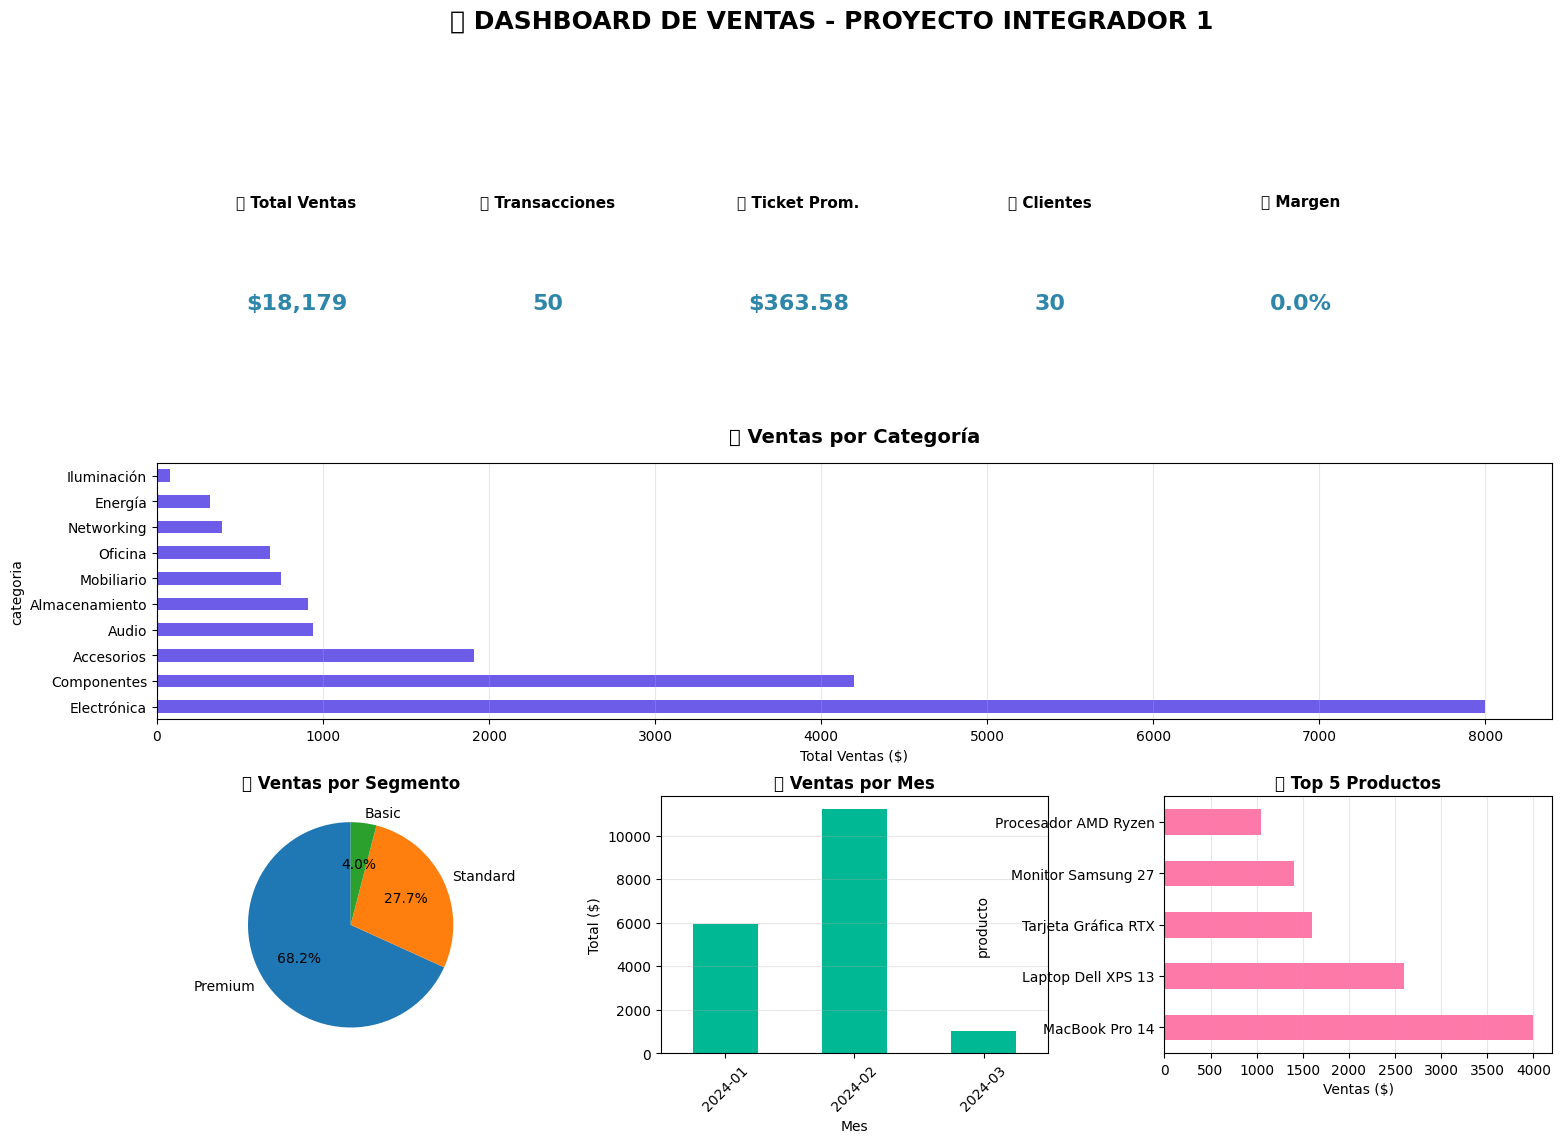

2025-12-07 17:27:35,146 - INFO - Dashboard generado y guardado


In [12]:
# Crear figura con subplots
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. KPIs principales (arriba)
ax_kpi = fig.add_subplot(gs[0, :])
ax_kpi.axis('off')

kpi_texts = [
    ('💰 Total Ventas', f"${kpis['total_ventas']:,.0f}"),
    ('🛒 Transacciones', f"{kpis['num_transacciones']:,}"),
    ('📊 Ticket Prom.', f"${kpis['ticket_promedio']:.2f}"),
    ('👥 Clientes', f"{kpis['clientes_unicos']}"),
    ('💹 Margen', f"{kpis['margen_promedio']:.1f}%")
]

for i, (titulo, valor) in enumerate(kpi_texts):
    x_pos = 0.1 + i * 0.18
    ax_kpi.text(x_pos, 0.7, titulo, ha='center', fontsize=11, fontweight='bold')
    ax_kpi.text(x_pos, 0.3, valor, ha='center', fontsize=16, fontweight='bold', color='#2E86AB')

# 2. Ventas por categoría
ax1 = fig.add_subplot(gs[1, :])
ventas_categoria['total_ventas'].plot(kind='barh', ax=ax1, color='#6C5CE7')
ax1.set_title('💼 Ventas por Categoría', fontsize=14, fontweight='bold', pad=15)
ax1.set_xlabel('Total Ventas ($)')
ax1.grid(axis='x', alpha=0.3)

# 3. Ventas por segmento (pie)
ax2 = fig.add_subplot(gs[2, 0])
ventas_segmento['total_ventas'].plot(kind='pie', ax=ax2, autopct='%1.1f%%', startangle=90)
ax2.set_title('👥 Ventas por Segmento', fontsize=12, fontweight='bold')
ax2.set_ylabel('')

# 4. Ventas por mes
ax3 = fig.add_subplot(gs[2, 1])
ventas_mes['total_ventas'].plot(kind='bar', ax=ax3, color='#00B894')
ax3.set_title('📅 Ventas por Mes', fontsize=12, fontweight='bold')
ax3.set_xlabel('Mes')
ax3.set_ylabel('Total ($)')
ax3.tick_params(axis='x', rotation=45)
ax3.grid(axis='y', alpha=0.3)

# 5. Top productos
ax4 = fig.add_subplot(gs[2, 2])
top_productos = df_ventas_final.groupby('producto')['total'].sum().nlargest(5)
top_productos.plot(kind='barh', ax=ax4, color='#FD79A8')
ax4.set_title('🏆 Top 5 Productos', fontsize=12, fontweight='bold')
ax4.set_xlabel('Ventas ($)')
ax4.grid(axis='x', alpha=0.3)

# Título principal
fig.suptitle('📊 DASHBOARD DE VENTAS - PROYECTO INTEGRADOR 1', 
             fontsize=18, fontweight='bold', y=0.98)

plt.savefig('../../outputs/proyecto_1/dashboard.png', dpi=300, bbox_inches='tight')
plt.show()

logger.info("Dashboard generado y guardado")

### 📈 Dashboard Ejecutivo: Visualización Integrada

**Concepto:** Dashboard multi-panel que presenta KPIs y métricas de negocio en una sola vista.

**Estructura con GridSpec:**
- **Fila 1:** KPIs principales (números grandes)
- **Fila 2:** Gráfico principal (ventas por categoría)
- **Fila 3:** Múltiples vistas (segmento, temporal, productos)

**Tipos de gráficos:**
- Barras horizontales: rankings y comparaciones
- Pie chart: proporciones y distribuciones
- Barras verticales: series temporales
- KPI cards: métricas clave destacadas

**Objetivo:** Vista ejecutiva one-pager para decisiones rápidas.

## 7. Carga de Datos (Load)

### 7.1 Cargar a Base de Datos SQLite

In [13]:
# Crear conexión a SQLite
db_path = '../../outputs/proyecto_1/ventas_analytics.db'
conn = sqlite3.connect(db_path)

try:
    # Cargar datos transformados
    df_ventas_final.to_sql('ventas', conn, if_exists='replace', index=False)
    logger.info(f"✅ Tabla 'ventas' cargada: {len(df_ventas_final)} registros")
    
    # Cargar agregaciones
    ventas_categoria.to_sql('ventas_categoria', conn, if_exists='replace')
    logger.info("✅ Tabla 'ventas_categoria' cargada")
    
    ventas_segmento.to_sql('ventas_segmento', conn, if_exists='replace')
    logger.info("✅ Tabla 'ventas_segmento' cargada")
    
    print("\n✅ DATOS CARGADOS EXITOSAMENTE EN SQLite")
    print(f"📁 Base de datos: {db_path}")
    
    # Verificar tablas
    cursor = conn.cursor()
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
    tablas = cursor.fetchall()
    
    print(f"\n📊 Tablas creadas:")
    for tabla in tablas:
        cursor.execute(f"SELECT COUNT(*) FROM {tabla[0]}")
        count = cursor.fetchone()[0]
        print(f"  • {tabla[0]}: {count} registros")
    
finally:
    conn.close()

logger.info("Carga completada")

2025-12-07 17:27:40,167 - INFO - ✅ Tabla 'ventas' cargada: 50 registros
2025-12-07 17:27:40,469 - INFO - ✅ Tabla 'ventas_categoria' cargada
2025-12-07 17:27:40,469 - INFO - ✅ Tabla 'ventas_categoria' cargada
2025-12-07 17:27:40,769 - INFO - ✅ Tabla 'ventas_segmento' cargada
2025-12-07 17:27:40,771 - INFO - Carga completada
2025-12-07 17:27:40,769 - INFO - ✅ Tabla 'ventas_segmento' cargada
2025-12-07 17:27:40,771 - INFO - Carga completada



✅ DATOS CARGADOS EXITOSAMENTE EN SQLite
📁 Base de datos: ../../outputs/proyecto_1/ventas_analytics.db

📊 Tablas creadas:
  • ventas: 50 registros
  • ventas_categoria: 10 registros
  • ventas_segmento: 3 registros


### 💾 Load Stage: Persistencia en Base de Datos

**Concepto:** Última etapa del ETL - cargar datos transformados y validados a destino permanente.

**Método `to_sql()`:**
- Crea tabla automáticamente desde DataFrame
- `if_exists='replace'`: sobrescribe tabla existente
- `index=False`: no guardar índice como columna

**Múltiples tablas:**
- **Datos detallados:** ventas completas (fact table)
- **Agregaciones:** tablas pre-calculadas para queries rápidos

**Verificación:** Query de conteo para confirmar carga exitosa.

**Formato alternativo:** Parquet para data lakes, mejor compresión y velocidad.

### 7.2 Exportar a Parquet

In [14]:
# Exportar a Parquet para análisis
parquet_path = '../../outputs/proyecto_1/ventas_final.parquet'
df_ventas_final.to_parquet(parquet_path, index=False)

print(f"✅ Datos exportados a Parquet: {parquet_path}")
print(f"📊 Tamaño del archivo: {os.path.getsize(parquet_path) / 1024:.2f} KB")

logger.info("Exportación a Parquet completada")

2025-12-07 17:27:43,863 - INFO - Exportación a Parquet completada


✅ Datos exportados a Parquet: ../../outputs/proyecto_1/ventas_final.parquet
📊 Tamaño del archivo: 16.07 KB


## 8. Reporte Final

### 8.1 Generar Resumen Ejecutivo

In [15]:
# Generar reporte completo
reporte = f"""
{'='*80}
📊 PROYECTO INTEGRADOR 1: PIPELINE ETL COMPLETO
{'='*80}

Fecha de ejecución: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

{'='*80}
1. EXTRACCIÓN
{'='*80}

Fuentes de datos procesadas:
  • Ventas (CSV): {len(df_ventas)} registros
  • Productos (CSV): {len(df_productos)} registros
  • Clientes (CSV): {len(df_clientes)} registros
  • Usuarios API: {len(df_usuarios_api)} registros

{'='*80}
2. TRANSFORMACIÓN
{'='*80}

Transformaciones aplicadas:
  ✅ Limpieza de valores nulos
  ✅ Normalización de fechas
  ✅ Eliminación de duplicados
  ✅ Enriquecimiento con datos relacionados
  ✅ Cálculo de métricas derivadas (margen, agregaciones temporales)

Registros finales: {len(df_ventas_final)}
Columnas totales: {len(df_ventas_final.columns)}

{'='*80}
3. KPIs PRINCIPALES
{'='*80}

💰 Total Ventas: ${kpis['total_ventas']:,.2f}
🛒 Transacciones: {kpis['num_transacciones']:,}
📈 Ticket Promedio: ${kpis['ticket_promedio']:.2f}
📊 Ticket Mediano: ${kpis['ticket_mediano']:.2f}
👥 Clientes Únicos: {kpis['clientes_unicos']}
📦 Productos Vendidos: {kpis['productos_vendidos']}
💹 Margen Promedio: {kpis['margen_promedio']:.2f}%

{'='*80}
4. TOP INSIGHTS
{'='*80}

🏆 Categoría con más ventas: {ventas_categoria.index[0]} (${ventas_categoria.iloc[0]['total_ventas']:,.2f})
👔 Segmento más valioso: {ventas_segmento.index[0]} (${ventas_segmento.iloc[0]['total_ventas']:,.2f})
📅 Mes con más ventas: {ventas_mes['total_ventas'].idxmax()} (${ventas_mes['total_ventas'].max():,.2f})

{'='*80}
5. CALIDAD DE DATOS
{'='*80}

{validator.generate_report()}

{'='*80}
6. ARCHIVOS GENERADOS
{'='*80}

📁 Base de datos: ventas_analytics.db
📄 Parquet: ventas_final.parquet
📊 Dashboard: dashboard.png
📈 CSV Agregados:
   • ventas_categoria.csv
   • ventas_segmento.csv
   • ventas_mes.csv
📝 KPIs: kpis.json
📋 Logs: proyecto_integrador_1.log

{'='*80}
✅ PIPELINE COMPLETADO EXITOSAMENTE
{'='*80}
"""

print(reporte)

# Guardar reporte
with open('../../outputs/proyecto_1/reporte_final.txt', 'w', encoding='utf-8') as f:
    f.write(reporte)

logger.info("Reporte final generado")
logger.info("=" * 80)
logger.info("PROYECTO INTEGRADOR 1 COMPLETADO EXITOSAMENTE")
logger.info("=" * 80)

2025-12-07 17:27:45,701 - INFO - Reporte final generado
2025-12-07 17:27:45,701 - INFO - ================================================================================
2025-12-07 17:27:45,702 - INFO - PROYECTO INTEGRADOR 1 COMPLETADO EXITOSAMENTE
2025-12-07 17:27:45,703 - INFO - ================================================================================
2025-12-07 17:27:45,701 - INFO - ================================================================================
2025-12-07 17:27:45,702 - INFO - PROYECTO INTEGRADOR 1 COMPLETADO EXITOSAMENTE
2025-12-07 17:27:45,703 - INFO - ================================================================================



📊 PROYECTO INTEGRADOR 1: PIPELINE ETL COMPLETO

Fecha de ejecución: 2025-12-07 17:27:45

1. EXTRACCIÓN

Fuentes de datos procesadas:
  • Ventas (CSV): 50 registros
  • Productos (CSV): 30 registros
  • Clientes (CSV): 30 registros
  • Usuarios API: 10 registros

2. TRANSFORMACIÓN

Transformaciones aplicadas:
  ✅ Limpieza de valores nulos
  ✅ Normalización de fechas
  ✅ Eliminación de duplicados
  ✅ Enriquecimiento con datos relacionados
  ✅ Cálculo de métricas derivadas (margen, agregaciones temporales)

Registros finales: 50
Columnas totales: 22

3. KPIs PRINCIPALES

💰 Total Ventas: $18,179.10
🛒 Transacciones: 50
📈 Ticket Promedio: $363.58
📊 Ticket Mediano: $219.98
👥 Clientes Únicos: 30
📦 Productos Vendidos: 30
💹 Margen Promedio: 0.00%

4. TOP INSIGHTS

🏆 Categoría con más ventas: Electrónica ($7,999.92)
👔 Segmento más valioso: Premium ($12,399.76)
📅 Mes con más ventas: 2024-02 ($11,234.49)

5. CALIDAD DE DATOS


📊 REPORTE DE CALIDAD DE DATOS

✅ No se encontraron problemas de calidad

## 📚 Conclusiones del Proyecto

### ✅ Lo que Lograste:

1. **Extracción Multi-Fuente**: CSV, API REST, SQLite
2. **Transformaciones Robustas**: Limpieza, normalización, enriquecimiento
3. **Validación de Calidad**: Checks automáticos de completitud, unicidad, rangos
4. **Análisis Avanzado**: KPIs, agregaciones por dimensiones
5. **Visualización Ejecutiva**: Dashboard completo con insights clave
6. **Carga Optimizada**: SQLite para queries, Parquet para análisis
7. **Logging Profesional**: Trazabilidad completa del proceso

### 🎯 Habilidades Desarrolladas:

- ✅ Diseño de arquitecturas ETL
- ✅ Programación orientada a objetos
- ✅ Manejo de errores y logging
- ✅ Calidad de datos
- ✅ Visualización de insights
- ✅ Documentación de pipelines

### 🚀 Próximos Pasos:

1. **Automatización**: Usar Apache Airflow para scheduling
2. **Escalabilidad**: Migrar a Spark para volúmenes grandes
3. **Cloud**: Desplegar en AWS/GCP/Azure
4. **Monitoreo**: Implementar alertas y métricas de performance
5. **CI/CD**: Automatizar tests y despliegues

---

**🎊 ¡FELICITACIONES! Has completado tu primer proyecto integrador de Ingeniería de Datos.**

---

---

## 🧭 Navegación

**← Anterior:** [🌐 APIs REST y Web Scraping para Ingeniería de Datos](08_apis_web_scraping.ipynb)

**Siguiente →:** [🚀 Proyecto Integrador 2: Pipeline Near Real-Time, Scheduling y Alertas →](10_proyecto_integrador_2.ipynb)

**📚 Índice de Nivel Junior:**
- [📊 Junior - 01. Introducción a la Ingeniería de Datos](01_introduccion_ingenieria_datos.ipynb)
- [🐍 Junior - 02. Python para Manipulación de Datos](02_python_manipulacion_datos.ipynb)
- [Pandas: Fundamentos para Análisis de Datos](03_pandas_fundamentos.ipynb)
- [SQL Básico para Ingeniería de Datos](04_sql_basico.ipynb)
- [Limpieza y Preparación de Datos](05_limpieza_datos.ipynb)
- [📊 Visualización de Datos en Ingeniería de Datos](06_visualizacion_datos.ipynb)
- [🔄 Git y Control de Versiones para Ingeniería de Datos](07_git_control_versiones.ipynb)
- [🌐 APIs REST y Web Scraping para Ingeniería de Datos](08_apis_web_scraping.ipynb)
- [🎯 Proyecto Integrador 1: Pipeline ETL Completo](09_proyecto_integrador_1.ipynb) ← 🔵 Estás aquí
- [🚀 Proyecto Integrador 2: Pipeline Near Real-Time, Scheduling y Alertas](10_proyecto_integrador_2.ipynb)

**🎓 Otros Niveles:**
- [Nivel Junior](../nivel_junior/README.md)
- [Nivel Mid](../nivel_mid/README.md)
- [Nivel Senior](../nivel_senior/README.md)
- [Nivel GenAI](../nivel_genai/README.md)
- [Negocio LATAM](../negocios_latam/README.md)
